In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import time

##Replication

In [ ]:
def call_payoff(S, K):
  return np.maximum(S-K, 0)

def forward_payoff(S, K): #long position
  return S - K
  
def digital_payoff(S, B): 
  S_copy = S.copy()
  S_copy[S_copy<B] = 0
  S_copy[S_copy>=B] = 1
  return S_copy

def touch_payoff(S, B1, B2): # problem: need to plug in running max rather than current S_T
  S_copy = S.copy()
  S_copy[S_copy<B1] = 0
  S_copy[S_copy>B2] = 0
  S_copy[(S_copy>=B1)*(S_copy<=B2)] = 1
  return S_copy

def put_payoff(S, K):
  return np.maximum(K-S, 0)

B1 = 1.05
B2 = 1.06
K = 0.95
F = 1.04
S = np.arange(0.9, 1.1, 0.001)

In [ ]:
#payoff: buy call(K)
def neverB1(S,B1,B2,K,F): 
    return call_payoff(S, K) * (1/(B1 - K))
    
#additional payoff: sell call(B2), sell digital call(B2)
def hitB2(S,B1,B2,K,F):
    return neverB1(S,B1,B2,K,F) - call_payoff(S, B2) * (1/(B1 - K)) - digital_payoff(S, B2)* (B2 - K)/(B1 - K)

#additional payoff: one-touch option, short forward,
def hitB1_neverB2(S,B1,B2,K,F):
    return hitB2(S,B1,B2,K,F) + np.ones(len(S)) * (B2 - B1)/(B1 - K) - forward_payoff(S, F) * (1/(B1 - K))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

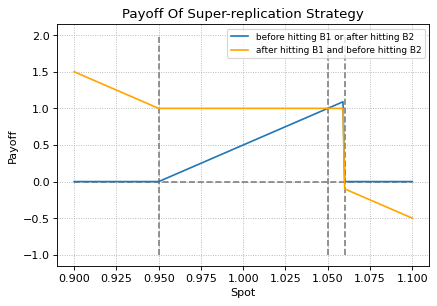

In [ ]:
plt.figure()
plt.figure(figsize=(6, 4), dpi=80)
plt.grid(linestyle='dotted')

plt.plot(S, hitB2(S,B1,B2,K,F), label='before hitting B1 or after hitting B2')
plt.plot(S, hitB1_neverB2(S,B1,B2,K,F), color = 'orange', label='after hitting B1 and before hitting B2')
plt.vlines(x= K, ymin = -1.0, ymax= 2.0, color = 'grey', linestyle='dashed')
plt.vlines(x= B1, ymin = -1.0, ymax= 2.0, color = 'grey', linestyle='dashed')
plt.vlines(x= B2, ymin = -1.0, ymax= 2.0, color = 'grey', linestyle='dashed')
plt.hlines(y=0.0, xmin=0.9, xmax=1.1, color='grey', linestyle='dashed')

plt.title('Payoff Of Super-replication Strategy')
plt.xlabel('Spot')
plt.ylabel('Payoff')
plt.legend(loc="upper right", prop={'size':8})
plt.savefig("super-rep.eps",format = "eps")

In [ ]:
## sub-replication

#payoff: sell put(K)
def neverB1_sub(S,B1,B2,K,F): 
    return -put_payoff(S, K) * (1/(B1 - K))
    
#no additional payoff
def hitB2_sub(S,B1,B2,K,F):
    return neverB1_sub(S,B1,B2,K,F)

#additional payoff: one-touch option, short forward
def hitB1_neverB2_sub(S,B1,B2,K,F):
    return hitB2_sub(S,B1,B2,K,F) + np.ones(len(S)) * (B2 - B1)/(B1 - K) - forward_payoff(S, F) * (1/(B1 - K))


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

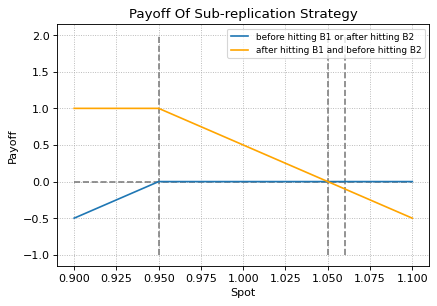

In [ ]:
plt.figure()
plt.figure(figsize=(6, 4), dpi=80)
plt.grid(linestyle='dotted')

plt.plot(S, hitB2_sub(S,B1,B2,K,F), label='before hitting B1 or after hitting B2')
plt.plot(S, hitB1_neverB2_sub(S,B1,B2,K,F), color = 'orange', label='after hitting B1 and before hitting B2')
plt.vlines(x= K, ymin = -1.0, ymax= 2.0, color = 'grey', linestyle='dashed')
plt.vlines(x= B1, ymin = -1.0, ymax= 2.0, color = 'grey', linestyle='dashed')
plt.vlines(x= B2, ymin = -1.0, ymax= 2.0, color = 'grey', linestyle='dashed')
plt.hlines(y=0.0, xmin=0.9, xmax=1.1, color='grey', linestyle='dashed')

plt.title('Payoff Of Sub-replication Strategy')
plt.xlabel('Spot')
plt.ylabel('Payoff')
plt.legend(loc="upper right", prop={'size':8})
plt.savefig("sub-rep.eps",format = "eps")

##Simulation

In [ ]:
### https://www.codearmo.com/python-tutorial/heston-model-simulation-python 
### https://blog.quantinsti.com/heston-model/

###Heston Model
def heston(S0, T, r, q, k, theta, V0, rho, eta, M, N):
  h = T / N
  sqrth = np.sqrt(T / N)

  z_s = sqrth * np.random.normal(size = (N, M)) # generates a N x M matrix of (0, h) normals for Stock S
  z_v = rho * z_s + np.sqrt(1 - rho**2) * sqrth * np.random.normal(size = (N, M)) # generates a N x M matrix of (0, h) normals with corr rho for Volatility V

  S_mat = np.zeros((N+1,M))
  V_mat = np.zeros((N+1,M))
  S_mat[0,:] = np.ones(M) * S0 
  V_mat[0,:] = np.ones(M) * V0

  for n in range(N):
      V_mat[n+1, :] = np.abs(V_mat[n,:] + k*(eta - V_mat[n,:]) * h + theta * np.sqrt(V_mat[n,:]) * z_s[n, :])
      S_mat[n+1, :] = S_mat[n,:]* np.exp((r - q - 0.5*V_mat[n,:])*h + np.sqrt(V_mat[n,:])*z_v[n, :])
  return S_mat

In [ ]:
def one_touch (S_mat, B, M, r, T):
  finals = np.array([1*(np.max(S_mat[:,i]) >= B) for i in range(M)]) # running max >= B

  return np.mean(finals) * np.exp(-r*T) # discount the price

In [ ]:
def euro_sim (S_mat, K, M, r, T, option_type):
  if option_type == 'call':
    finals = np.array([np.maximum(S_mat[-1,i] - K, 0) for i in range(M)])
  elif option_type == 'put':
    finals = np.array([np.maximum(K - S_mat[-1,i], 0) for i in range(M)])
  else:
    print("Please enter a valid option type: 'call' or 'put'! ")
    return None

  return np.mean(finals) * np.exp(-r*T) # discount the price

In [ ]:
def euro_bs(S, T, K, r, sigma, option_type):
  d1 = (np.log(S / K) + (r + (sigma ** 2) / 2) * T) / (sigma * np.sqrt(T))
  d2 = d1 - sigma*np.sqrt(T)

  dis_factor = np.exp(-r*T)

  if option_type == 'call':
    price = S*norm.cdf(d1) - K*dis_factor*norm.cdf(d2)

  elif option_type == 'put':
    price = K*dis_factor*norm.cdf(-d2) - S*norm.cdf(-d1)

  else:
    print("Please enter a valid option type: 'call' or 'put'! ")
    return None

  return price


In [ ]:
def digital_bs (S, T, K, r, sigma, option_type): # payoff=1 if ITM
  x = (np.log(K/S) - (r-0.5*sigma**2)*T) / (sigma * np.sqrt(T))
  
  dis_factor = np.exp(-r*T)

  if option_type == 'call':
    price = dis_factor * norm.cdf(-x)

  elif option_type == 'put':
    price = dis_factor * norm.cdf(x)

  else:
    print("Please enter a valid option type: 'call' or 'put'! ")
    return None

  return price

In [ ]:
def digital_sim(S_mat, K, M, r, T, option_type):# payoff=1 if ITM
    if option_type == 'call':
        finals = np.array([1 * (np.max(S_mat[-1,i]) > K) for i in range(M)])
    elif option_type == 'put':
        finals = np.array([1 * (np.max(S_mat[-1,i]) <= K) for i in range(M)])
    else:
        print("Please enter a valid option type: 'call' or 'put'!")
        return None
    return np.mean(finals) * np.exp(-r*T) # avg of 1 simuition * discount

In [ ]:
# our original strategy
# initial value of strategy G(K, B1, B2) = (C(K) - C(B2)) * (1/(B1-K)) + O(B2) * (B2-B1)/(B1-K) - digital_call(B2) * (B2-B1)/(B1-K)

def upper(S,T,K,r,sigma,stock_path,B1,B2,M):
    call_K = euro_sim(stock_path, K, M, r, T, 'call')
    call_B2 = euro_sim(stock_path, B2, M, r, T, 'call')
    touch_B2 = one_touch(stock_path, B2, M, r, T)
    digital_call_B2 = digital_sim(stock_path, B2, M, r, T,'call')
    upper_bound = (call_K - call_B2) * (1/(B1-K)) + touch_B2 * (B2-B1)/(B1-K) - digital_call_B2 * (B2-B1)/(B1-K)
    return upper_bound

# initial value of strategy L(K, B1, B2) = -P(B) * (1/(B1-K)) + O(B2) * (B2-B1)/(B1-K)

def lower(S, T, K, r, sigma, stock_path, B1, B2, M):
    put_K = euro_sim(stock_path, K, M, r, T, 'put')
    touch_B2 = one_touch (stock_path, B2, M, r, T)
    lower_bound = - put_K * (1/(B1-K)) + touch_B2 * ((B2 - B1)/(B1 - K))
    return lower_bound

In [ ]:
# alternative strategy
def upper_alter(S,T,K,r,sigma,stock_path,B1,B2,M):
    call_K = euro_sim(stock_path, K, M, r, T, 'call')
    call_B2 = euro_sim(stock_path, B2, M, r, T, 'call')
    touch_B2 = one_touch(stock_path, B2, M, r, T)
    digital_call_B2 = digital_sim(stock_path, B2, M, r, T,'call')
    upper_bound = (call_K - call_B2) * (1/(B1-K)) + touch_B2 * ((B2-B1)/(B1-K)-1) - digital_call_B2 * (B2-B1)/(B1-K)
    return upper_bound

def lower_alter(S, T, K, r, sigma, stock_path, B1, B2, M):
    put_K = euro_sim(stock_path, K, M, r, T, 'put')
    touch_B2 = one_touch (stock_path, B2, M, r, T)
    lower_bound = - put_K * (1/(B1-K)) + touch_B2 * ((B2 - B1)/(B1 - K) - 1)
    return lower_bound

In [ ]:
# brown strategy
def upper_brown(S,T,K,r,sigma,stock_path,B1,M):
    call_K = euro_sim(stock_path, K, M, r, T, 'call')
    upper_bound = call_K * (1/(B1-K))
    return upper_bound

def lower_brown(S,T,K,r,sigma,stock_path,B1,M):
    call_B1 = euro_sim(stock_path, B1, M, r, T, 'call')
    put_K = euro_sim(stock_path, K, M, r, T, 'put')
    digital_call_B1 = digital_sim(stock_path, B1, M, r, T,'call')
    lower_bound = (call_B1 - put_K) * (1/(B1-K)) + digital_call_B1
    return lower_bound

In [ ]:
# parameters
r, q, rho = 0, 0, 0
sig = 0.15
kappa = 3
eta = 0.2**2
theta = 0.4
B1= 1.05
B2= 1.06
K = 0.9
T = 0.25
M = 100000
N = 1000

In [ ]:
# find the optimal K
S0 = np.arange(0.9, 1.05, 0.01)
K_upper = np.zeros(len(S0))
K_lower = np.zeros(len(S0))
K_upper_alter = np.zeros(len(S0))
K_lower_alter = np.zeros(len(S0))
K_upper_brown = np.zeros(len(S0))
K_lower_brown = np.zeros(len(S0))

j = 0
for S in S0:
  stock_path = heston(S, T, r, q, kappa, theta, sig**2, rho, eta, M, N)
  K_arr = np.arange(0,B1,0.01)
  upper_price = np.zeros(len(K_arr))
  lower_price = np.zeros(len(K_arr))
  upper_price_alter = np.zeros(len(K_arr))
  lower_price_alter = np.zeros(len(K_arr))
  upper_price_brown = np.zeros(len(K_arr))
  lower_price_brown = np.zeros(len(K_arr))
  i=0
  for k in K_arr:
    upper_price[i] = upper(S, T, k, r, sig, stock_path, B1, B2, M)
    lower_price[i] = lower(S, T, k, r, sig, stock_path, B1, B2, M)
    upper_price_alter[i] = upper_alter(S, T, k, r, sig, stock_path, B1, B2, M)
    lower_price_alter[i] = lower_alter(S, T, k, r, sig, stock_path, B1, B2, M)
    upper_price_brown[i] = upper_brown(S,T,k,r,sig,stock_path,B1,M)
    lower_price_brown[i] = lower_brown(S,T,k,r,sig,stock_path,B1,M)
    i += 1

  # second one touch option: K
  K_upper[j] = K_arr[np.argmin(upper_price)]
  K_lower[j] = K_arr[np.argmax(lower_price)]

  # brown: K
  K_upper_brown[j] = K_arr[np.argmin(upper_price_brown)]
  K_lower_brown[j] = K_arr[np.argmax(lower_price_brown)]

  # alternative: K
  K_upper_alter[j] = K_arr[np.argmin(upper_price_alter)]
  K_lower_alter[j] = K_arr[np.argmax(lower_price_alter)]
  j += 1

In [ ]:
# K_upper_brown = np.array([1., 1., 1., 1., 1., 1., 0.99, 0.99, 0.99, 0.98, 0.98, 0.97, 0.95, 0.94, 0.91, 0.79])
# K_lower_brown = np.array([0.7, 0.71, 0.73, 0.75, 0.77, 0.78, 0.8, 0.82, 0.84, 0.86, 0.88, 0.91, 0.93, 0.95, 0.99, 1.03])

In [ ]:
# Heston price for one touch option with barrier B1
one_touch_price

array([0.06051, 0.07728, 0.09678, 0.12372, 0.15535, 0.19163, 0.23934,
       0.29216, 0.35072, 0.42173, 0.4959 , 0.58419, 0.67671, 0.7755 ,
       0.87845, 1.     ])

In [ ]:
# Heston price for one touch option with barrier B2
S0 = np.arange(0.9, 1.05, 0.01)
one_touch_price = np.zeros(len(S0))
i = 0
for s in S0:
  stock_path = heston(s, T, r, q, kappa, theta, sig**2, rho, eta, M, N)
  one_touch_price[i] = one_touch(stock_path, B2, M, r, T)
  i += 1
print(one_touch_price)

[0.04679 0.05915 0.08003 0.10064 0.12656 0.15696 0.19603 0.24126 0.29677
 0.35575 0.42869 0.50226 0.58752 0.68049 0.77858 0.88125]


In [ ]:
# find price bound with the optimal K

S0 = np.arange(0.9, 1.05, 0.01)
one_touch_price = np.zeros(len(S0))
upper_bound = np.zeros(len(S0))
lower_bound = np.zeros(len(S0))
upper_bound_alter = np.zeros(len(S0))
lower_bound_alter = np.zeros(len(S0))
upper_bound_brown = np.zeros(len(S0))
lower_bound_brown = np.zeros(len(S0))

for i in range(len(S0)):
  stock_path = heston(S0[i], T, r, q, kappa, theta, sig**2, rho, eta, M, N)
  one_touch_price[i] = one_touch(stock_path, B1, M, r, T)
  upper_bound[i] = upper(S0[i], T, K_upper[i], r, sig, stock_path, B1, B2, M) #1.033
  lower_bound[i] = lower(S0[i], T, K_lower[i], r, sig, stock_path, B1, B2, M)
  upper_bound_alter[i] = upper_alter(S0[i], T, K_upper_alter[i], r, sig, stock_path, B1, B2, M) #1.033
  lower_bound_alter[i] = lower_alter(S0[i], T, K_lower_alter[i], r, sig, stock_path, B1, B2, M)
  upper_bound_brown[i] = upper_brown(S0[i], T, K_upper_brown[i], r, sig, stock_path, B1, M) 
  lower_bound_brown[i] = lower_brown(S0[i], T, K_lower_brown[i], r, sig, stock_path, B1, M)

In [ ]:
# the output of the pricing bound
print(upper_bound_brown)
print(lower_bound_brown)

[0.08230611 0.10594336 0.13124903 0.16855763 0.20872254 0.25553057
 0.31198259 0.37427812 0.44633403 0.52919692 0.61065346 0.70159915
 0.79004086 0.87011113 0.94425924 1.00111326]
[0.03402353 0.04454948 0.05582379 0.07256008 0.09079458 0.11319944
 0.14098461 0.17329993 0.21293166 0.26210255 0.317072   0.38377542
 0.4640721  0.55422989 0.68251148 0.96214311]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

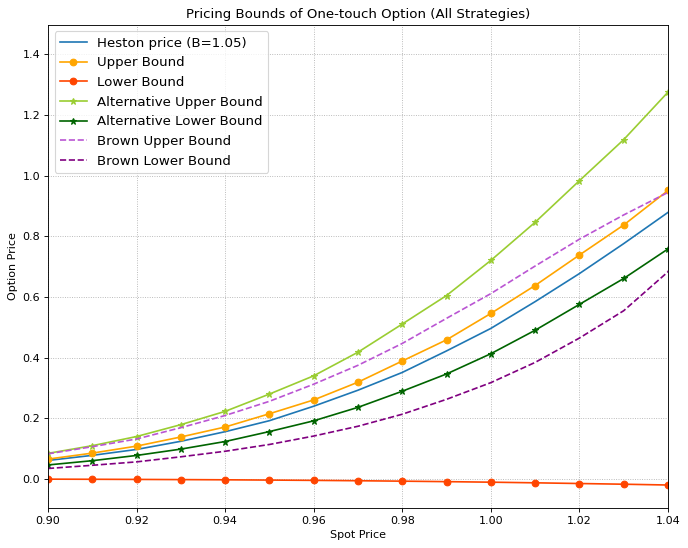

In [ ]:
# Pricing bounds of one-touch option with all strategies
plt.figure()
plt.figure(figsize=(10,8), dpi=80)
plt.grid(linestyle='dotted')
plt.plot(S0, one_touch_price, label = 'Heston price (B=1.05)')
plt.plot(S0, upper_bound, 'o-', label = 'Upper Bound', color = 'orange')
plt.plot(S0, -lower_bound, 'o-', label = 'Lower Bound', color = 'orangered')
plt.plot(S0, upper_bound_alter, '*-', label = 'Alternative Upper Bound', color = 'yellowgreen')
plt.plot(S0, -lower_bound_alter, '*-', label = 'Alternative Lower Bound', color = 'darkgreen')
plt.plot(S0, upper_bound_brown, label = 'Brown Upper Bound', color = 'mediumorchid', linestyle='dashed')
plt.plot(S0, lower_bound_brown, label = 'Brown Lower Bound', color = 'purple', linestyle = 'dashed')

plt.xlim([0.9, 1.04])
plt.xlabel("Spot Price")
plt.ylabel("Option Price")
plt.title("Pricing Bounds of One-touch Option (All Strategies)")
plt.legend(loc="upper left", prop={'size':12})
plt.savefig("bounds.eps",format = "eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

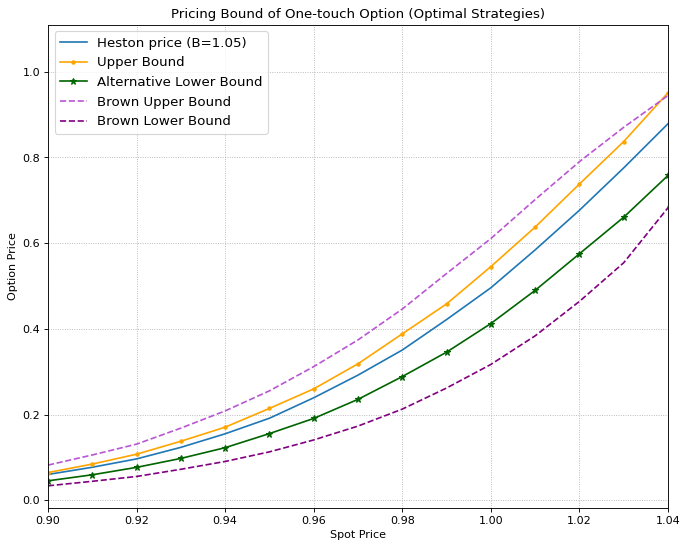

In [ ]:
# # Pricing bounds of one-touch option with optimal strategies
plt.figure()
plt.figure(figsize=(10,8), dpi=80)
plt.grid(linestyle='dotted')
plt.plot(S0, one_touch_price, label = 'Heston price (B=1.05)')
plt.plot(S0, upper_bound, '.-', label = 'Upper Bound', color = 'orange')
plt.plot(S0, -lower_bound_alter, '*-', label = 'Alternative Lower Bound', color = 'darkgreen')
plt.plot(S0, upper_bound_brown, label = 'Brown Upper Bound', color = 'mediumorchid', linestyle='dashed')
plt.plot(S0, lower_bound_brown, label = 'Brown Lower Bound', color = 'purple', linestyle = 'dashed')

plt.xlim([0.9, 1.04])
plt.xlabel("Spot Price")
plt.ylabel("Option Price")
plt.title("Pricing Bound of One-touch Option (Optimal Strategies)")
plt.legend(loc="upper left", prop={'size':12})
plt.savefig("bounds.eps",format = "eps")